In [1]:
import pyroomacoustics as pra
from pyroomacoustics.doa import detect_peaks
import numpy as np
import matplotlib.pyplot as plt
from src.file_io import load_signal_from_wav
from lib.custom import create_doa_object, perform_fft_on_frames

In [2]:
room_dim = [10, 10]
corners = np.array([[0, 0], [0, room_dim[1]], room_dim, [room_dim[0], 0]]).T  # [x,y]

window_size = 512
hop_size = 128
freq_range = [300, 3500]
frame_length = 100

In [5]:
# def plot_music_spectra(doa):
#     estimated_angles = doa.grid.azimuth
#     music_spectra = doa.spectra_storage

#     for i in range(len(music_spectra)):
#         plt.polar(estimated_angles, music_spectra[i], color="blue", alpha=0.2)

#     plt.title("MUSIC Spectrum (Polar Coordinates)")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

def plot_music_spectra(doa, mph, ans):
    estimated_angles = doa.grid.azimuth
    music_spectra = doa.spectra_storage

    plt.figure(figsize=(12, 5))

    # 極座標でのMUSICスペクトルをプロット
    ax_polar = plt.subplot(1, 2, 1, projection="polar")
    for spectrum in music_spectra:
        plt.polar(estimated_angles, spectrum, color="blue", alpha=0.2)
    # ax_polar.set_ylim(0, 18)
    plt.title("MUSIC Spectrum (Polar Coordinates)")
    plt.grid(True)

    # 直交座標でのMUSICスペクトルをプロット
    ax_cartesian = plt.subplot(1, 2, 2)
    for spectrum in music_spectra:
        plt.plot(np.rad2deg(estimated_angles), spectrum, color="blue", alpha=0.2)  # ラジアンを度に変換
    # ax_cartesian.set_ylim(0, 18)
    plt.title("MUSIC Spectrum (Cartesian Coordinates)")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Magnitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    results = np.zeros((len(music_spectra), len(ans)))
    cnt = 0

    for i, spectrum in enumerate(music_spectra):
        idx = detect_peaks(spectrum, mph=mph, show=False)
        used = np.zeros(len(idx))
        for j, an in enumerate(ans):
            for k, idx_element in enumerate(idx):
                if abs(an - idx_element) <= 3:
                    results[i][j] = 1
                    used[k] = 1
        cnt += len(idx) - np.sum(used)
    results = np.sum(results, axis=0)
    print("results:", results / len(music_spectra))
    print("cnt:", cnt)

r=0.05


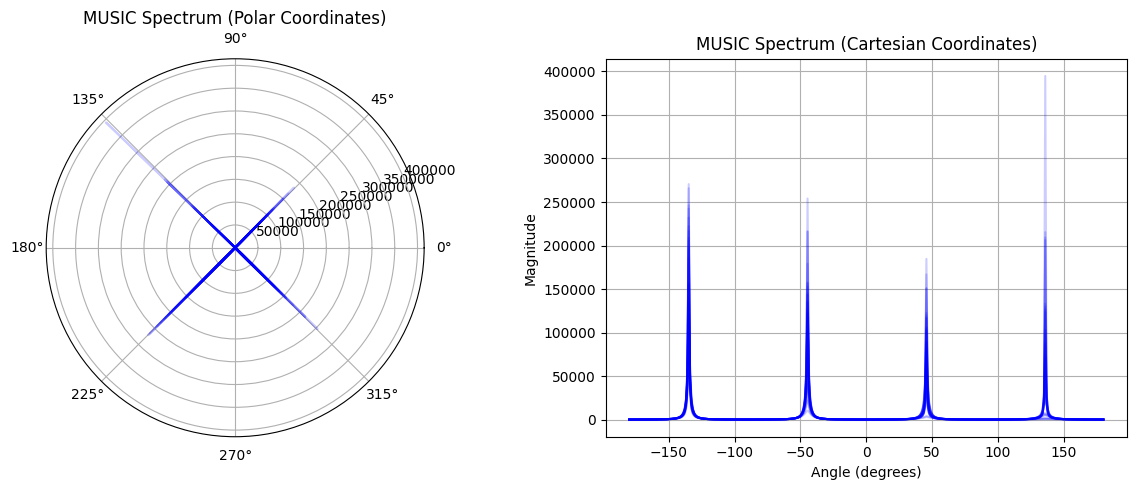

results: [1. 1. 1. 1.]
cnt: 0.0
r=0.10


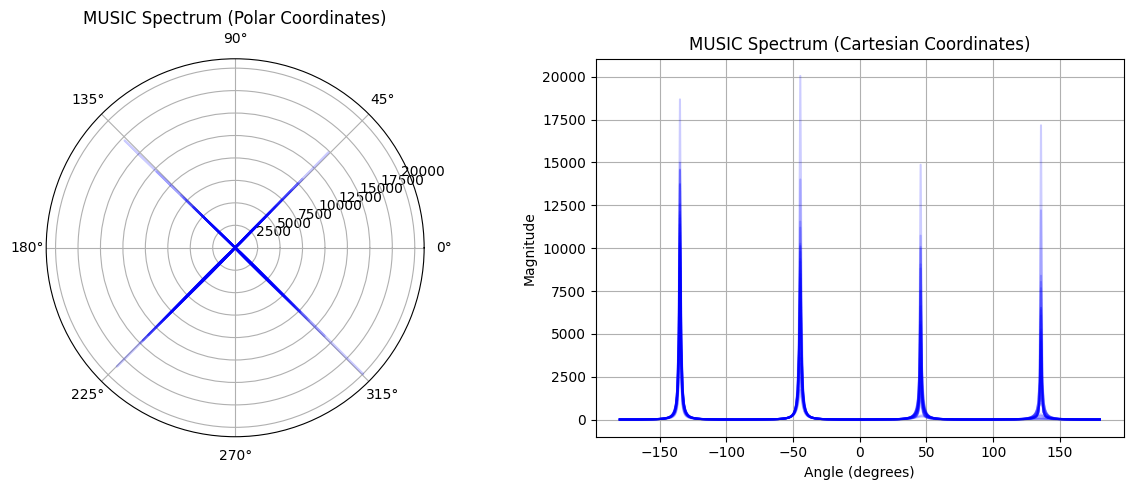

results: [1. 1. 1. 1.]
cnt: 57.0
r=0.15


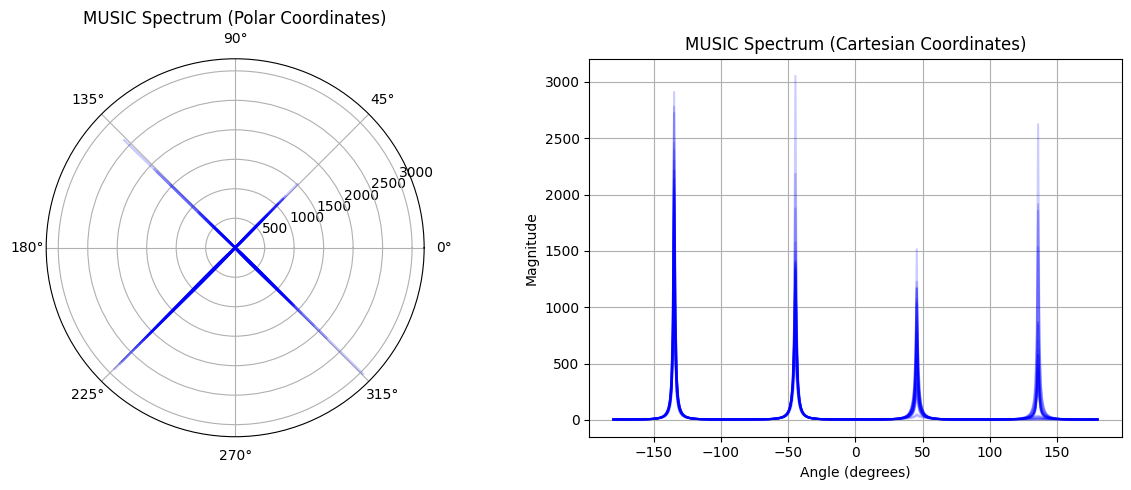

results: [1. 1. 1. 1.]
cnt: 92.0
r=0.20


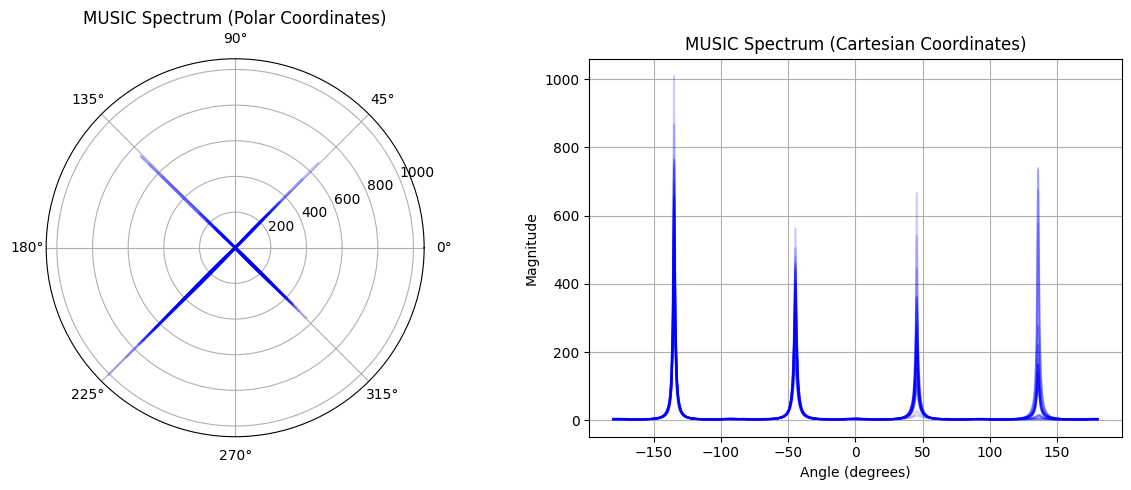

results: [1.   1.   1.   0.96]
cnt: 163.0
r=0.25


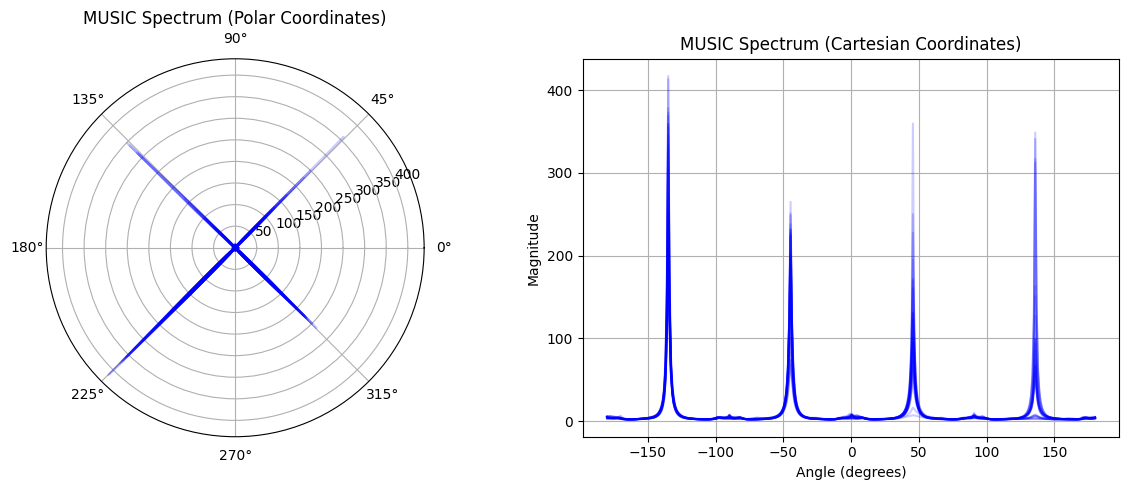

results: [1.   1.   1.   0.88]
cnt: 203.0
r=0.30


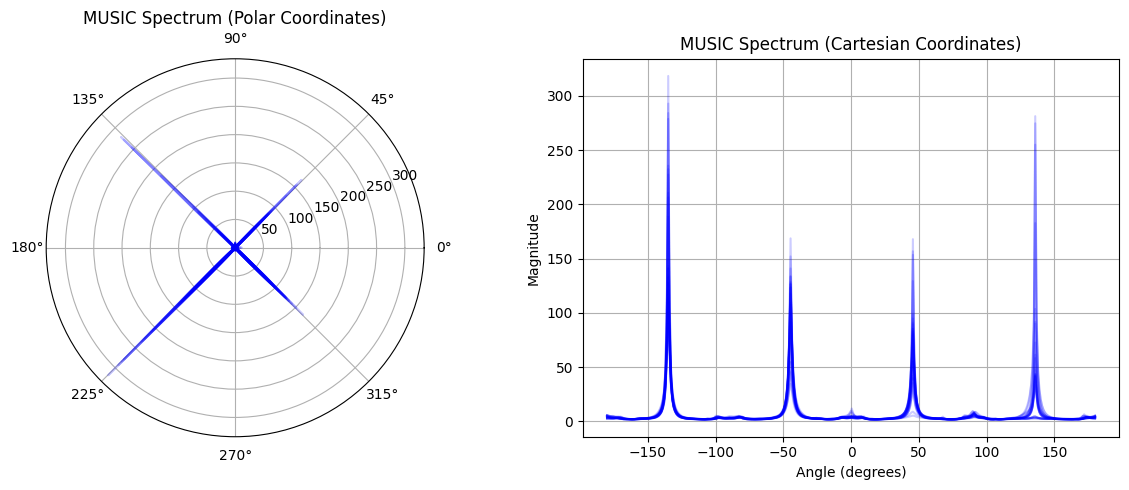

results: [1.   1.   1.   0.84]
cnt: 148.0
r=0.35


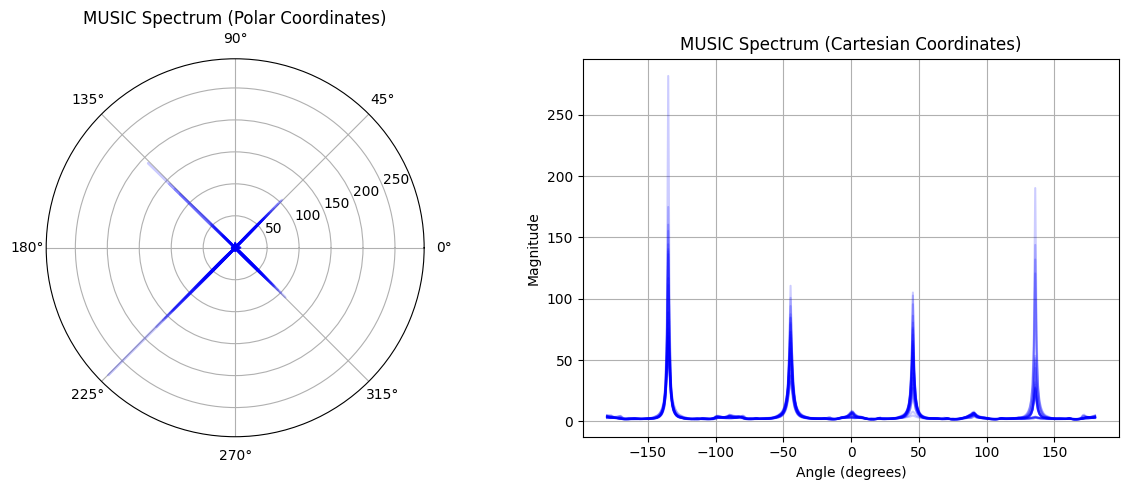

results: [1.   1.   1.   0.84]
cnt: 114.0
r=0.40


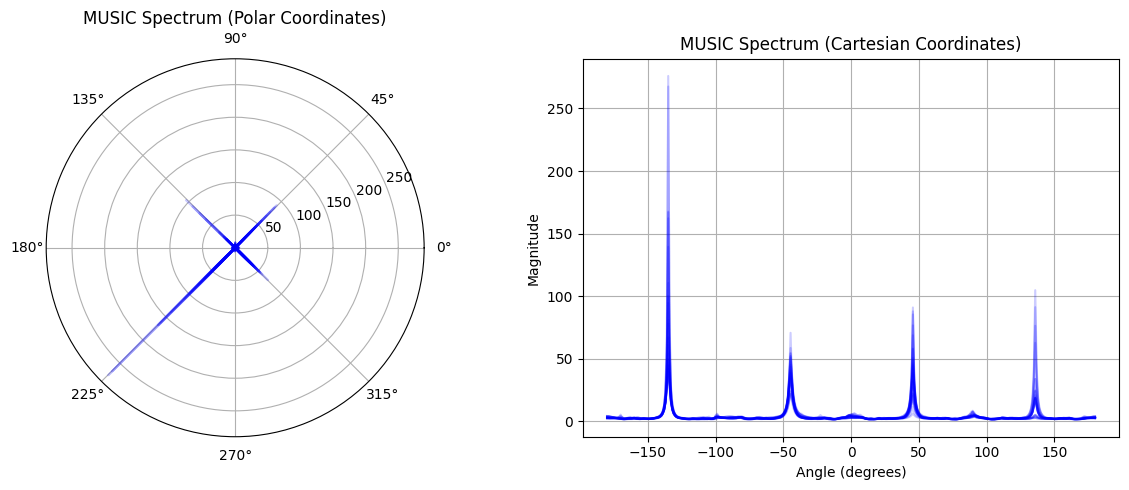

results: [1.   1.   1.   0.88]
cnt: 103.0
r=0.45


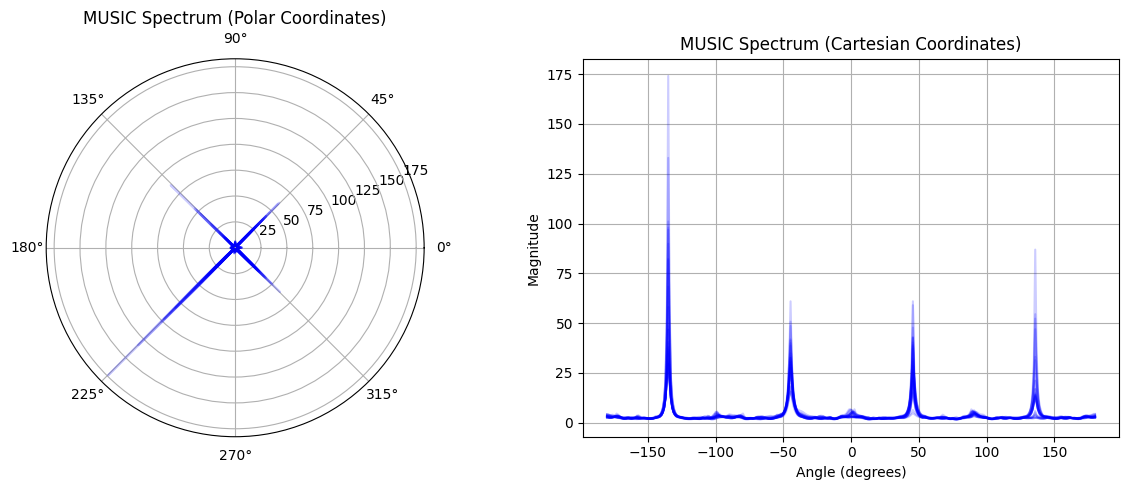

results: [1.  1.  1.  0.8]
cnt: 80.0
r=0.50


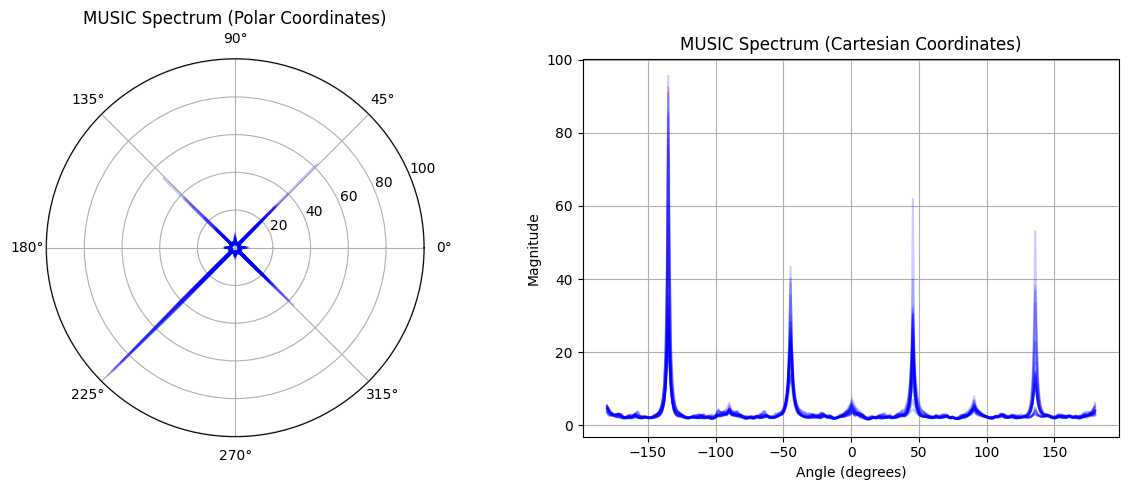

results: [1.   1.   1.   0.88]
cnt: 111.0
r=0.55


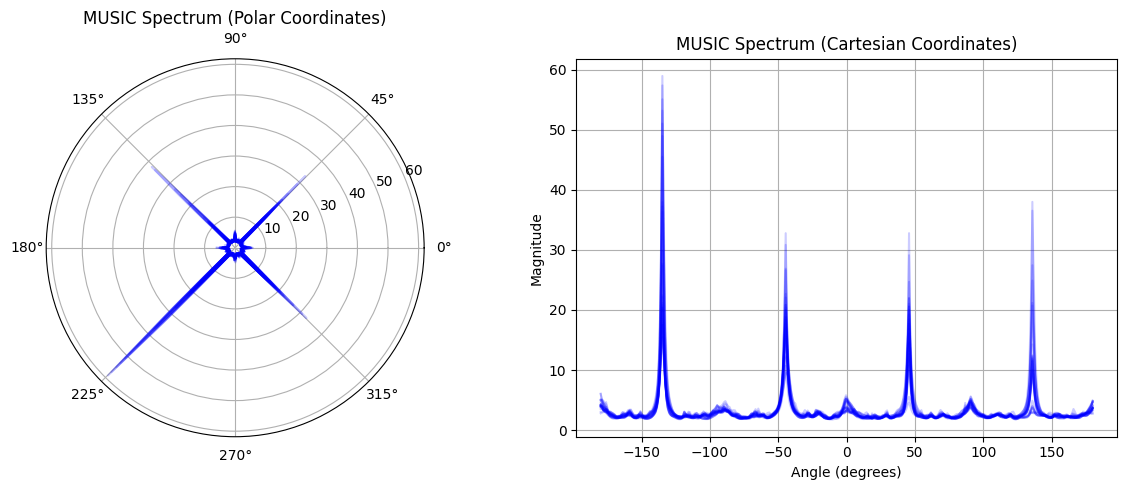

results: [1.   1.   1.   0.88]
cnt: 74.0
r=0.60


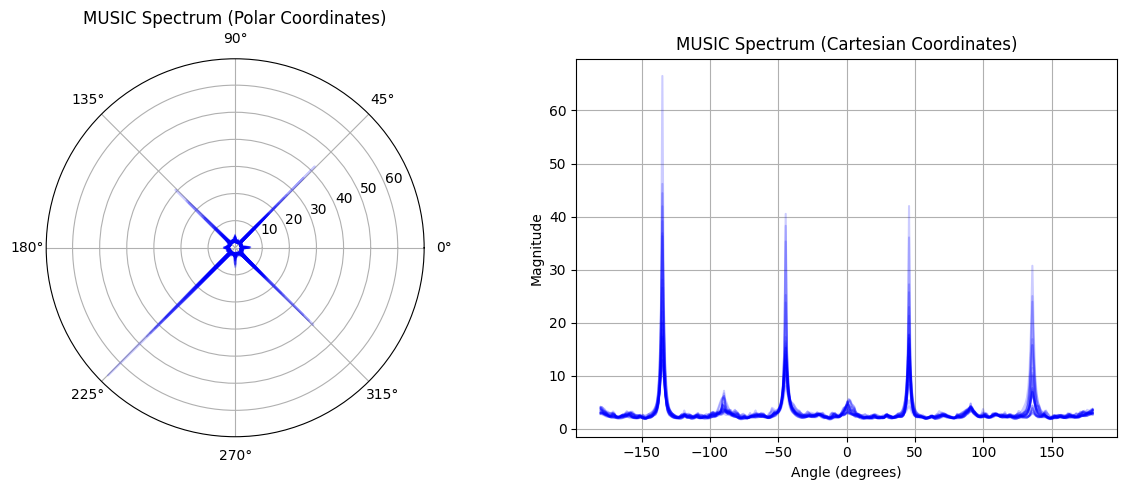

results: [1.   1.   1.   0.84]
cnt: 74.0


In [6]:
padding = 1.5
ans = [45, 135, 225, 315]

for r in np.arange(0.05, 0.65, 0.05):
# for r in np.arange(0.45, 0.65, 0.05):
    print(f"r={r:.2f}")

    room = pra.Room.from_corners(corners, fs=16000, max_order=0)

    # 音源
    for i, position in enumerate(
        [
            [padding, padding],
            [10 - padding, padding],
            [10 - padding, 10 - padding],
            [padding, 10 - padding],
        ]
    ):
        signal = load_signal_from_wav(f"data/voice/{i}.wav", room.fs)
        room.add_source(position, signal=signal)

    # マイクロホンアレイ
    mic_positions = pra.circular_2D_array(center=(5, 5), M=8, phi0=0, radius=r)
    room.add_microphone_array(pra.MicrophoneArray(mic_positions, room.fs))

    # room.plot()
    # plt.show()

    # room.simulate(snr=-12)
    room.simulate()
    simulated_signals = room.mic_array.signals

    X_source = perform_fft_on_frames(simulated_signals, window_size, hop_size)

    doa = create_doa_object(
        method="SEVD",
        source_noise_thresh=100,
        mic_positions=mic_positions,
        fs=room.fs,
        nfft=window_size,
        num_src=4,
        output_dir=".",
    )

    for f in range(0, X_source.shape[2], frame_length // 4):
        xs = X_source[:, :, f : f + frame_length]
        doa.locate_sources(xs, None, freq_range=freq_range, auto_identify=True)

    plot_music_spectra(doa, 3.5, ans)
    # break

In [9]:
import numpy as np
import scipy.signal

fs = 48000  # サンプリング周波数
duration = 1  # ノイズの持続時間（秒）
noise = np.random.normal(0, 1, int(fs * duration))  # 白色ガウスノイズの生成

# 低域通過フィルターの設定
b, a = scipy.signal.butter(4, 0.1)  # 4次のバターワースフィルター、カットオフ周波数は0.1（サンプリング周波数の10%）

# フィルターを適用して風のノイズを生成
wind_noise = scipy.signal.filtfilt(b, a, noise)

# ノイズを再生
# Audioをインポートして再生する
from IPython.display import Audio

# Audio(wind_noise, rate=fs)
Audio(noise, rate=fs)

In [10]:
b, a

(array([0.0004166, 0.0016664, 0.0024996, 0.0016664, 0.0004166]),
 array([ 1.        , -3.18063855,  3.86119435, -2.11215536,  0.43826514]))